# Конфиг

In [1]:
import os
from LookGenerator.config.config import DatasetConfig

config = DatasetConfig(os.environ)
config.show_details()

DATASET_DIR
BACKGROUND_DATASET


In [2]:
print("BACKGROUND_DATASET: {}, DATASET_DIR: {}".format(config.BACKGROUND_DATASET, config.DATASET_DIR))

 -- C:\Users\dimka\PycharmProjects\data\zalando-hd-resized\


# Импорты

In [1]:
from torchvision.transforms import ToTensor, ToPILImage, PILToTensor
import torch
from torch.utils.data import DataLoader
import os
import numpy as np
from typing import Tuple
import cv2
import random

from PIL import Image
from torch.utils.data import Dataset
from LookGenerator.datasets.person_segmentation_dataset import PersonSegmentationDataset, PersonSegmentationDatasetMultichannelV2
from LookGenerator.networks.segmentation import UNet
import albumentations
import torchvision.transforms as transforms
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks.losses import UnitSegmentationLoss
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks_training.utils import check_path_and_creat

# for dataset
from LookGenerator.datasets.utils import load_image

# Работа с данными

In [2]:
transform_train = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.RandomBrightnessContrast(brightness_limit=(0.1,0.3), contrast_limit=(0.2,0.7), p =0.2),
        albumentations.Equalize(p = 0.2),
        albumentations.GaussNoise(p = 0.2),
        albumentations.Affine(translate_percent=0.1, scale=(0.8, 1), rotate=(-90,90), p=0.2),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

transform_valid = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

In [ ]:
# TODO: проверить
class UnitPersonSegmentationDataset(Dataset):
    """Dataset for a Person Segmentation task"""

    def __init__(self, root, transform_input=None, transform_output=None, augment=None):
        """
        Args:
            root: directory with all images
            transform_input: transform to be performed on an input, from pytorch
            transform_output: transform to be performed on an output, from pytorch
            augment: transforms from albumentations to be used on image and mask
        """

        super().__init__()

        self.root = root
        self.transform_input = transform_input
        self.transform_output = transform_output
        self.augment = augment

        self._files_list = [ file.split('.')[0] for file in os.listdir(self.root + r"\image")]

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            idx: The index of data sample

        Returns: A Pair of X and y objects for segmentation
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        to_tensor = ToTensor()

        input_ = np.array(load_image(self.root, "image", self._files_list[idx], ".jpg"))
        bin_target = np.array(load_image(self.root, "agnostic-v3.3", self._files_list[idx], ".png"))
        multi_target = np.array(load_image(self.root, "image-parse-v3.1-multichannel", self._files_list[idx], ".png"))

        target = torch.cat((bin_target, multi_target), dim=1)

        if self.augment:
            transformed = self.augment(image=input_, mask=target)
            input_ = transformed['image']
            target = transformed['mask']

        input_ = to_tensor(input_)
        target = to_tensor(target)

        if self.transform_input:
            input_ = self.transform_input(input_)

        if self.transform_output:
            input_ = self.transform_output(target)

        return input_, target

    def __len__(self):
        """
        Returns: the length of the dataset
        """

        return len(self._files_list)

In [ ]:
train_dataset = UnitPersonSegmentationDataset(root=None,
                                              augment=transform_train)

val_dataset = UnitPersonSegmentationDataset(root=None,
                                              augment=transform_valid)

## Проверка датасета на корректность работы трансформаций

In [5]:
import matplotlib.pyplot as plt

def _print(image, mask):
    fig = plt.figure(figsize=(20, 14))

    fig.add_subplot( 1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))

    fig.add_subplot( 1, 2, 2)
    plt.imshow(mask[0], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 192]) torch.Size([1, 256, 192]) 9751


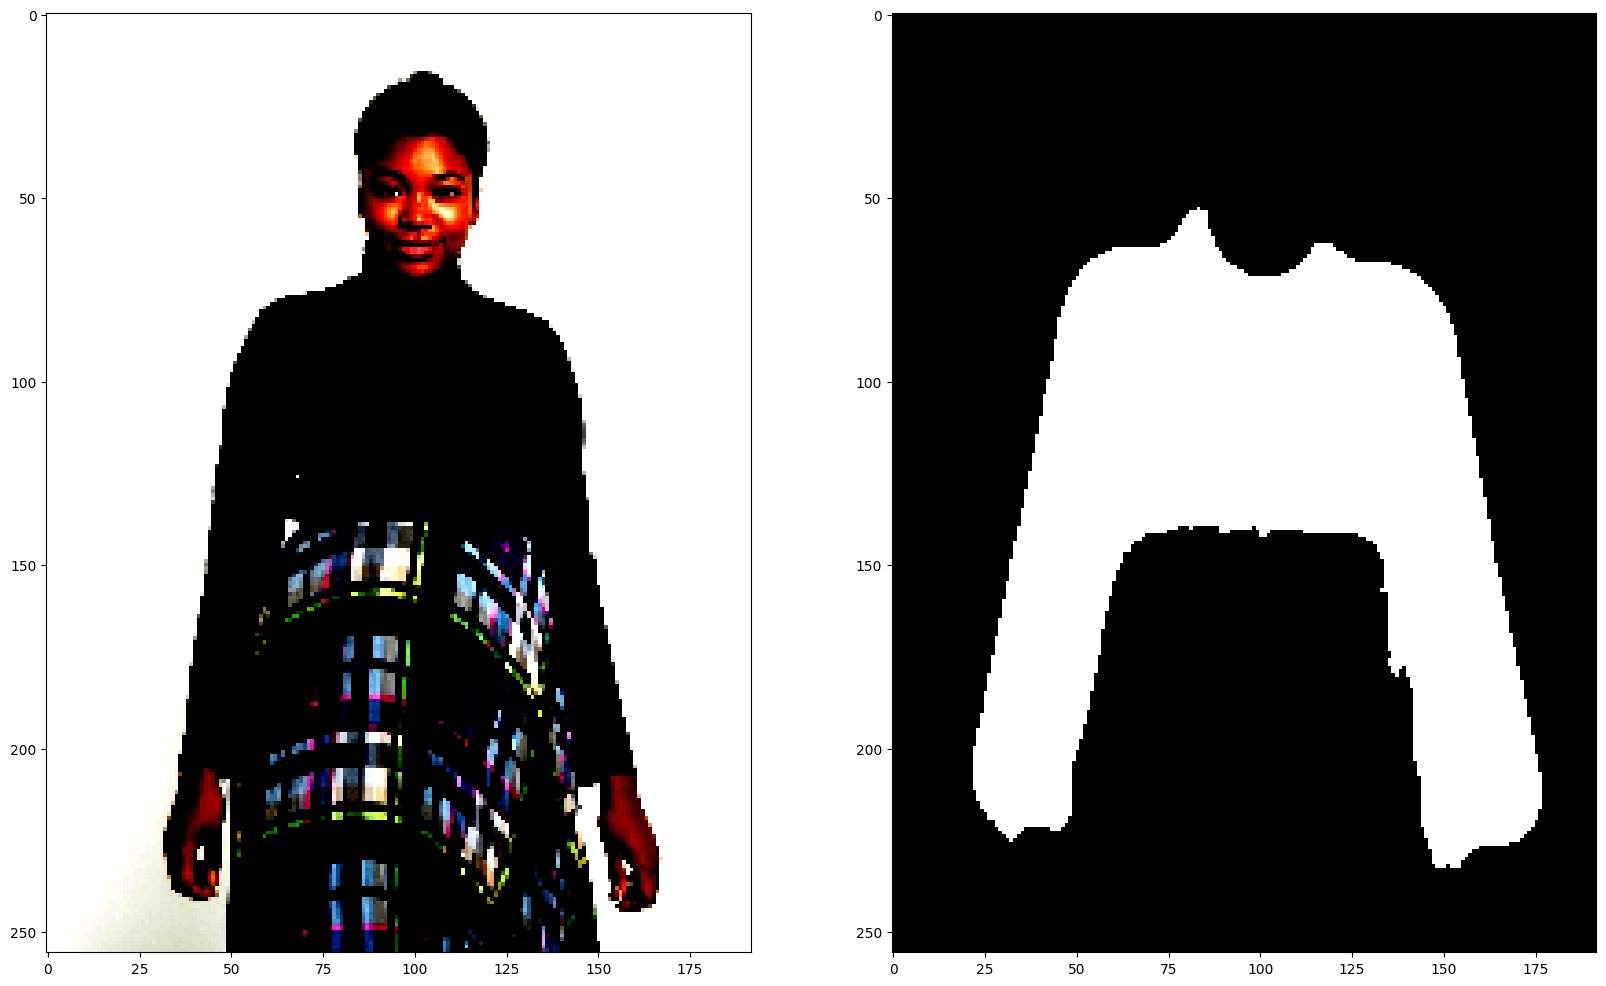

In [6]:
number = np.random.randint(0, 11647)


image, mask = train_dataset.__getitem__(number)
print(image.shape, mask.shape, number)
_print(image, mask)


## Создание даталоадеров

In [7]:
batch_size_train = 64
batch_size_val = 32
pin_memory = True
num_workers = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)


# Обучение

In [8]:
model_unet = UNet(in_channels=3, out_channels = 13, features=(32, 64, 128, 256, 512))

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [9]:
#model = load_model(model, r'путь')                 # активировать, если модель надо загрузить и дообучить
optimizer = torch.optim.Adam(model_unet.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = UnitSegmentationLoss()

### Создание папки для сохранения весов

In [25]:
save_directory = r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmetationBackground\weights\testResultsFeatures_32_64_128_256_512"
check_path_and_creat(save_directory)


True

### Цикл обучения

In [20]:
epoch_num = 10

In [12]:
trainer = Trainer(
    model_=model_unet, optimizer=optimizer, criterion=criterion,
    device=device, save_directory=save_directory, save_step=1, verbose=True
)

In [26]:
trainer.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch_num=epoch_num)

start time 03-06-2023 20:18


100%|██████████| 182/182 [01:33<00:00,  1.96it/s]


Epoch 0 of 9, train loss: 0.00007
Epoch end time 03-06-2023 20:19


100%|██████████| 64/64 [00:08<00:00,  7.15it/s]


Epoch 0 of 9, val loss: 0.00018
Epoch end time 03-06-2023 20:19


100%|██████████| 182/182 [01:25<00:00,  2.13it/s]


Epoch 1 of 9, train loss: 0.00007
Epoch end time 03-06-2023 20:21


100%|██████████| 64/64 [00:07<00:00,  8.65it/s]


Epoch 1 of 9, val loss: 0.00020
Epoch end time 03-06-2023 20:21


100%|██████████| 182/182 [01:25<00:00,  2.13it/s]


Epoch 2 of 9, train loss: 0.00006
Epoch end time 03-06-2023 20:22


100%|██████████| 64/64 [00:09<00:00,  7.10it/s]


Epoch 2 of 9, val loss: 0.00021
Epoch end time 03-06-2023 20:22


100%|██████████| 182/182 [01:26<00:00,  2.10it/s]


Epoch 3 of 9, train loss: 0.00008
Epoch end time 03-06-2023 20:24


100%|██████████| 64/64 [00:08<00:00,  7.98it/s]


Epoch 3 of 9, val loss: 0.00021
Epoch end time 03-06-2023 20:24


100%|██████████| 182/182 [01:31<00:00,  1.99it/s]


Epoch 4 of 9, train loss: 0.00007
Epoch end time 03-06-2023 20:25


100%|██████████| 64/64 [00:09<00:00,  6.94it/s]


Epoch 4 of 9, val loss: 0.00017
Epoch end time 03-06-2023 20:26


100%|██████████| 182/182 [01:27<00:00,  2.08it/s]


Epoch 5 of 9, train loss: 0.00006
Epoch end time 03-06-2023 20:27


100%|██████████| 64/64 [00:09<00:00,  6.97it/s]


Epoch 5 of 9, val loss: 0.00021
Epoch end time 03-06-2023 20:27


100%|██████████| 182/182 [01:27<00:00,  2.08it/s]


Epoch 6 of 9, train loss: 0.00006
Epoch end time 03-06-2023 20:29


100%|██████████| 64/64 [00:07<00:00,  8.34it/s]


Epoch 6 of 9, val loss: 0.00020
Epoch end time 03-06-2023 20:29


100%|██████████| 182/182 [01:14<00:00,  2.43it/s]


Epoch 7 of 9, train loss: 0.00006
Epoch end time 03-06-2023 20:30


100%|██████████| 64/64 [00:07<00:00,  8.30it/s]


Epoch 7 of 9, val loss: 0.00024
Epoch end time 03-06-2023 20:30


100%|██████████| 182/182 [01:16<00:00,  2.38it/s]


Epoch 8 of 9, train loss: 0.00006
Epoch end time 03-06-2023 20:32


100%|██████████| 64/64 [00:08<00:00,  7.29it/s]


Epoch 8 of 9, val loss: 0.00021
Epoch end time 03-06-2023 20:32


100%|██████████| 182/182 [01:29<00:00,  2.04it/s]


Epoch 9 of 9, train loss: 0.00005
Epoch end time 03-06-2023 20:33


100%|██████████| 64/64 [00:12<00:00,  5.31it/s]

Epoch 9 of 9, val loss: 0.00022
Epoch end time 03-06-2023 20:33
end time 03-06-2023 20:33
delta 0:15:48.071145


### Вывод графиков и их сохранение

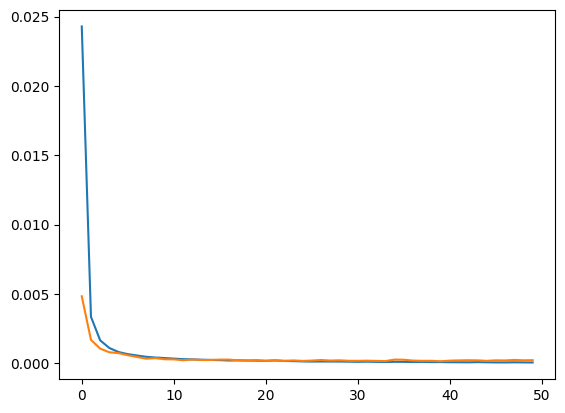

In [27]:
trainer.draw_history_plots()

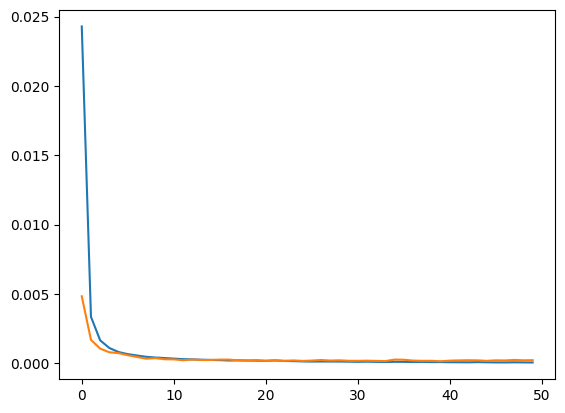

In [28]:
trainer.save_history_plots(save_directory)

### Сохранение readme файла в папке весов с описание архитектуры сети

In [ ]:
trainer.create_readme(save_directory)

### Подсчет метрики

In [17]:
from LookGenerator.networks.losses import IoUMetricBin
iou_sum = 0
metric = IoUMetricBin()
model_unet.eval()
model_unet.to(device)
for image, mask in val_dataloader:
     image = image.to(device)
     mask = mask.to(device)
     output = model_unet(image)
     iou_sum += metric(output, mask).item()

iou_sum / len(val_dataloader)

0.9169193785637617

### Вывод summary модели

In [18]:
from torchsummary import summary
summary(model_unet.to('cuda'), (3, 256, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 192]             896
       BatchNorm2d-2         [-1, 32, 256, 192]              64
         LeakyReLU-3         [-1, 32, 256, 192]               0
         LeakyReLU-4         [-1, 32, 256, 192]               0
           Conv3x3-5         [-1, 32, 256, 192]               0
            Conv2d-6         [-1, 32, 256, 192]           9,248
       BatchNorm2d-7         [-1, 32, 256, 192]              64
           Conv3x3-8         [-1, 32, 256, 192]               0
         LeakyReLU-9         [-1, 32, 256, 192]               0
        LeakyReLU-10         [-1, 32, 256, 192]               0
          Conv5x5-11         [-1, 32, 256, 192]               0
        MaxPool2d-12          [-1, 32, 128, 96]               0
           Conv2d-13          [-1, 64, 128, 96]          18,496
      BatchNorm2d-14          [-1, 64, 